<a href="https://colab.research.google.com/github/AntoineHocquet/DS-assignment/blob/main/SED_Rough_Paths.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project: **Semantic Edge Detection with rough paths**
## By *Antoine Hocquet*


# Preliminaries



**Dataset:**

This notebook uses a local version of the `DAVIS-2017-trainval-480p` dataset downloadable at the URL
[https://davischallenge.org/davis2017/code.html](https://davischallenge.org/davis2017/code.html)



## Required libraries for this notebook

In [11]:
# We import all the API needed in the notebook
!pip install torchinfo

# File access
from google.colab import drive # to access dataset
import zipfile # to unzip dataset
import os # for file operations

# Basic Python
import random
import numpy as np
import matplotlib.pyplot as plt

# Computer vision
import cv2
from skimage import io, filters # to detect edges in annotations
from PIL import Image

# Pytorch APIs
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary # for schematic overview of nn


## Data access

Access Google Drive where dataset `DAVIS-2017-trainval-480p` is located

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


Main paths for file access

In [12]:
zip_path = "/content/drive/MyDrive/interview/DAVIS-2017-trainval-480p.zip"  # path of zip file
extract_path = "/content/drive/MyDrive/interview/DAVIS-2017-trainval-480p"  # path of extracted data
save_path = '/content/drive/MyDrive' # path to save models

List containing all video names

In [13]:
video_names = os.listdir(extract_path + "/DAVIS/JPEGImages/480p")
print(video_names)

['bear', 'bike-packing', 'blackswan', 'bmx-bumps', 'bmx-trees', 'boat', 'boxing-fisheye', 'breakdance', 'breakdance-flare', 'bus', 'camel', 'car-roundabout', 'car-shadow', 'car-turn', 'cat-girl', 'classic-car', 'color-run', 'cows', 'crossing', 'dance-jump', 'dance-twirl', 'dancing', 'disc-jockey', 'dog', 'dog-agility', 'dog-gooses', 'dogs-jump', 'dogs-scale', 'drift-chicane', 'drift-straight', 'drift-turn', 'drone', 'elephant', 'flamingo', 'goat', 'gold-fish', 'hike', 'hockey', 'horsejump-high', 'horsejump-low', 'india', 'judo', 'kid-football', 'kite-surf', 'kite-walk', 'koala', 'lab-coat', 'lady-running', 'libby', 'lindy-hop', 'loading', 'longboard', 'lucia', 'mallard-fly', 'mallard-water', 'mbike-trick', 'miami-surf', 'motocross-bumps', 'motocross-jump', 'motorbike', 'night-race', 'paragliding', 'paragliding-launch', 'parkour', 'pigs', 'planes-water', 'rallye', 'rhino', 'rollerblade', 'schoolgirls', 'scooter-black', 'scooter-board', 'scooter-gray', 'sheep', 'shooting', 'skate-park', 

Unzip data (might take 15min). Only necessary for first use.

In [ ]:
# # UNCOMMENT IF NECESSARY
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print("Extraction done!")

## Frequently used macros

### Python functions

In [14]:
def pick_video(extract_path = extract_path, name=None):
    """
    Inputs:
    - extract_path: path where dataset is unzipped
    - name: a video name in the directory list
    Picks a video at random unless a specific name is given
    Returns the video name, path to frames, and path to annotations.
    """
    if name is None:
        video_names = os.listdir(extract_path + "/DAVIS/JPEGImages/480p")
        video_name = random.choice(video_names)
    else:
        video_name = name
    video_path = extract_path + f"/DAVIS/JPEGImages/480p/{video_name}"
    annotation_path = extract_path + f"/DAVIS/Annotations/480p/{video_name}"
    print("The newly chosen video is:", video_name)

    return video_name, video_path, annotation_path


def tensor_describe(tensor):
    """
    Prints the shape, mean, std, min, and max of a PyTorch tensor.
    """
    print("Tensor Shape:", tensor.shape)
    print("Mean:", tensor.mean().item())
    print("Std:", tensor.std().item())
    print("Min:", tensor.min().item())
    print("Max:", tensor.max().item())
    print("-"*75)


# MIN MAX NORMALIZATION FOR NUMPY ARRAY
def normalize_min_max_numpy(x):
    """
    Normalizes a NumPy array to the range [0, 1] using min-max normalization.
    """
    return (x - x.min()) / (x.max() - x.min())

# 3 sided plots for model evaluation
def side_comparison(original_image, ground_truth, model_prediction):
    """
    Plots three images side by side: original image, ground truth, and model prediction.
    Input:
    - original_image: Pytorch tensor of shape [1,3,256,256]
    - ground_truth: Pytorch tensor of shape [1,1,256,256]
    - model_prediction: Pytorch tensor of shape [1,1,256,256]
    """
    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Plot Original Image
    image_np = original_image.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ax[0].imshow(image_np)
    ax[0].set_title("Original Image")
    ax[0].axis("off")

    # Plot Ground Truth (Annotation)
    ground_truth_np = ground_truth.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ax[1].imshow(ground_truth_np, cmap="gray")
    ax[1].set_title("Ground Truth Edge Map")
    ax[1].axis("off")

    # Plot Model's Predicted Edge Map
    output_np = model_prediction.squeeze(0).permute(1, 2, 0).cpu().numpy()
    ax[2].imshow(output_np, cmap="gray")
    ax[2].set_title("Predicted Edge Map (Trained Model)")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

### `DAVISDataset` Pytorch Dataset

Creating a *PyTorch Dataset* for easy loading of Video Frames and edges (masks)

**Rem**:
- videos are collections of *.JPG files* labelled as `'00000.jpg'`, `'00001.jpg'`, etc.
- annotations are *.PNG files*, labelled correspondingly as `'00000.png'`, `'00001.png'` and so on.

In [15]:
# PYTORCH TRANSFORMS
# min-max normalization
normalize_min_max = transforms.Lambda(lambda x: (x - x.min()) / (x.max() - x.min()))

# Resize to 256 x 256 and apply standard normalization (RGB)
resize_normalize = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    normalize_min_max
])

# Similar resize, but also extract edge
resize_extract_edge = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# PYTORCH CLASS TO LOAD DATASET AND OBTAIN EDGES
class DAVISDataset(Dataset):
    """
    Custom PyTorch Dataset for DAVIS frames and edge masks.
    Attributes:
    - image_dir: Path to frames
    - annotation_dir: Path to annotations
    - transform_img: Transformation for image
    - transform_ann: Transformation for annotation
    """
    def __init__(self, image_dir, annotation_dir, transform_img=None, transform_ann=None):
        self.image_dir = image_dir  # Path to frames
        self.annotation_dir = annotation_dir    # Path to edge masks
        self.transform_img = transform_img  # Transformations for image
        self.transform_ann = transform_ann  # Transformations for annotation

        # List all frame filenames (assume they match between images & masks)
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]

        # Load image
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Load corresponding Annotation
        annotation_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png"))  # Assuming PNG format for masks


        #mask = Image.open(mask_path).convert("L")  # Convert to grayscale

        # Apply transformations
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # Apply same transformations to both

        return image, mask  # Return both image and mask tensors

# dummy test
video_name = "bear"
_, video_path, annotation_path = pick_video(name=video_name)
dataset= DAVISDataset(image_dir = video_path, mask_dir = annotation_path, transform = resize_normalize)
image, mask = dataset[0]
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

The newly chosen video is: bear
Image shape: torch.Size([3, 256, 256])
Mask shape: torch.Size([1, 256, 256])


### Training setup

In [8]:
# Training setup (for tasks 1 to 4)

def train_model(model, dataset, batch_size, loss, epochs=5, lr=1e-3):
    """
    Train the model on the given dataset.

    Parameters:
    - model: PyTorch model
    - dataset: PyTorch dataset
    - batch_size: Batch size for training
    - loss: Loss function
    - epochs: Number of training epochs
    - lr: Learning rate

    Returns:
    - model: Trained PyTorch model
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    n = epochs//10 if (epochs//10 != 0) else 1 # avoid division by 0

    losses = []

    model.train() # set model to training mode

    for epoch in range(epochs):
        model.train() # set model to training mode
        epoch_loss = 0.0

        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images) # forward pass

            loss_value = loss(outputs, masks) # compute loss
            loss_value.backward() # backpropagation
            optimizer.step() # update weights

            epoch_loss += loss_value.item()

        losses.append(epoch_loss)

        if (epoch+1) % n == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(dataloader):.4f}")

    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.show()

    return model

In [9]:
# Pick video randomly
video_name1, video_path1, annotation_path1 = pick_video()
dataset1= DAVISDataset(image_dir = video_path1, mask_dir = annotation_path1, transform = resize_normalize)
dataloader1 = DataLoader(dataset1, batch_size=1, shuffle=False)

# get the nth pair (image, edge): [1,3,256,256], [1,1,256,256]
n=5
dataloader_iter1 = iter(dataloader1)  # Create an iterator
for i in range(n):  # Skip the first (n-1) batches
    next(dataloader_iter1)
image_n, edge_n = next(dataloader_iter1)

tensor_describe(image_n)
tensor_describe(edge_n)


The newly chosen video is: horsejump-low
Tensor Shape: torch.Size([1, 3, 256, 256])
Mean: 0.4525620937347412
Std: 0.21339121460914612
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.037954505532979965
Std: 0.14495287835597992
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------


## Display Frames and Edges side by side.


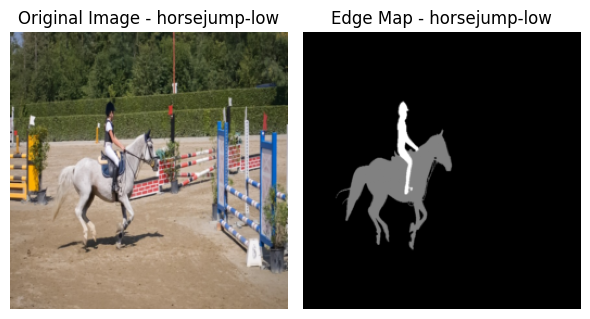

In [10]:
# convert fully processed tensors to numpy arrays for visualization
image_n_np = image_n.squeeze(0).permute(1, 2, 0).cpu().numpy()
edge_n_np = edge_n.squeeze(0).permute(1, 2, 0).cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(6, 6))

axes[0].imshow(image_n_np)
axes[0].set_title(f"Original Image - {video_name1}")
axes[0].axis("off")

axes[1].imshow(edge_n_np, cmap="gray")
axes[1].set_title(f"Edge Map - {video_name1}")
axes[1].axis("off")

plt.tight_layout()

**Rem:** annotations are not binary as such: they need to be processed to reduce channels from 3 to 1 (grayscale).

# Building a first Encoder-Decoder architecture

**Approach:** We build an Encoder-Decoder architecture to train a neural network for mask prediction. We import as encoder the `ResNet18` architecture with pretrained weights.

In [ ]:
# ENCODER
# We use pretrained ResNest18
class Encoder2(nn.Module):
    def __init__(self, pretrained=True):
        super(Encoder2, self).__init__()

        # Load ResNet18
        resnet = models.resnet18(pretrained=pretrained)

        # Remove the fully connected layers to keep it convolutional
        # Select layers to extract features for skip connections
        self.encoder = nn.Sequential(*list(resnet.children())[:-2])
        #self.features = []  # initialize to empty list #MODIFIED

        # register forward hooks to capture features maps from desired layers
        # Capture from layer1, layer2, layer3, and layer4
        # This will give us 4 skip connections as expected by the decoder
        # resnet.layer1.register_forward_hook(self.save_features) #MODIFIED
        # resnet.layer2.register_forward_hook(self.save_features) #MODIFIED
        # resnet.layer3.register_forward_hook(self.save_features) #MODIFIED
        # resnet.layer4.register_forward_hook(self.save_features) #MODIFIED
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4


    # Define hook function to save features
    # def save_features(self, module, input, output): #MODIFIED
    #    self.features.append(output)  #MODIFIED

    def forward(self, x):
        #_ = self.encoder(x)  # execute forward to trigger hooks #MODIFIED
        x = self.encoder[0](x) # conv1
        x = self.encoder[1](x) # bn1
        x = self.encoder[2](x) # relu
        x = self.encoder[3](x) # maxpool
        # Save outputs from desired layers: layer1, layer2, layer3, layer4
        encoder_features = []
        x = layer_out1 = self.layer1(x) # layer1
        encoder_features.append(layer_out1) # Save output from layer1
        x = layer_out2 = self.layer2(x) # layer2
        encoder_features.append(layer_out2) # Save output from layer2
        x = layer_out3 = self.layer3(x) # layer3
        encoder_features.append(layer_out3) # Save output from layer3
        x = layer_out4 = self.layer4(x) # layer4
        encoder_features.append(layer_out4) # Save output from layer4

        # Reverse the list to match order with original code
        # encoder_features = self.features[::-1] #MODIFIED
        #self.features = []  # clear list before next call #MODIFIED
        return encoder_features, encoder_features[-1]  # return encoder_features and bottleneck


# DECODER
class Decoder2(nn.Module):
    def __init__(self, encoder_channels=[512, 256, 128, 64], out_channels=1):
        super(Decoder2, self).__init__()

                # Upsampling with Bilinear + Conv (Solution 1)
        self.up1 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(encoder_channels[0], 256, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(256 + encoder_channels[1], 128, kernel_size=3, padding=1),  # Skip connection
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(128 + encoder_channels[2], 64, kernel_size=3, padding=1),  # Skip connection
            nn.ReLU()
        )
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(64 + encoder_channels[3], 32, kernel_size=3, padding=1),  # Skip connection
            nn.ReLU()
        )
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)  # 1x1 Conv for final mask

    def forward(self, x, encoder_features):
        x = self.up1(x)
        x = torch.cat([x, encoder_features[3]], dim=1)  # Skip connection
        x = self.up2(x)
        x = torch.cat([x, encoder_features[2]], dim=1)  # Skip connection
        x = self.up3(x)
        x = torch.cat([x, encoder_features[1]], dim=1)  # Skip connection
        x = self.up4(x)
        x = torch.cat([x, encoder_features[0]], dim=1)  # Skip connection
        x = self.final_conv(x)
        return torch.sigmoid(x)  # Final probability map


# COMBINE
class EdgeDetectionModel2(nn.Module):
    def __init__(self, pretrained=True):
        super(EdgeDetectionModel2, self).__init__()
        self.encoder = Encoder2(pretrained=pretrained)  # ResNet18 backbone
        self.pinch = nn.SiLU()  # Apply Swish at the bottleneck
        self.decoder = Decoder2()

    def forward(self, x):
        # Store intermediate feature maps from the encoder
        encoder_features = []
        for layer in self.encoder.children():
            x = layer(x)
            encoder_features.append(x)

        bottleneck = self.pinch(encoder_features[-1])  # Apply non-linearity at bottleneck
        output = self.decoder(bottleneck, encoder_features[:-1])  # Pass skip connections
        return output


# We can load a dummy instance of model here to visualize its layers.
model_dummy= EdgeDetectionModel2(pretrained=False)
summary(model_dummy, input_size=(1, 3, 256, 256))

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Sequential: 2, Conv2d: 3, BatchNorm2d: 3, ReLU: 3, MaxPool2d: 3, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Sequential: 2, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, Sequential: 4, Conv2d: 5, BatchNorm2d: 5, ReLU: 4, BasicBlock: 3, Conv2d: 4, BatchNorm2d: 4, ReLU: 4, Conv2d: 4, BatchNorm2d: 4, ReLU: 4]

## Overfit on a selected Image

'Sanity check': check if the network can at least memorize the mapping between input image and edge.

The newly chosen video is: cat-girl
Image shape: torch.Size([1, 3, 256, 256])
Mask shape: torch.Size([1, 1, 256, 256])


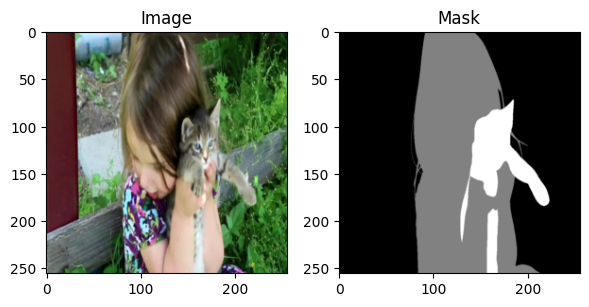

In [ ]:
# dummy test
video_name = "cat-girl"
_, video_path, annotation_path = pick_video(name=video_name)

# Creates dataloader with only one pair (image,mask)
dataset= DAVISDataset(image_dir = video_path, mask_dir = annotation_path, transform = resize_normalize)
dataset2 = Subset(dataset, [40])
dataloader2 = DataLoader(dataset2, batch_size=1, shuffle=False)

# Extracts the pair (simply for visualization)
image, mask = next(iter(dataloader2))
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

#plot image and mask
fig, axes = plt.subplots(1, 2, figsize=(6,8))
axes[0].imshow(image[0].permute(1,2,0))
axes[0].set_title("Image")
axes[1].imshow(mask[0].permute(1,2,0), cmap='gray')
axes[1].set_title("Mask")

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 126MB/s]


Epoch 10/100, Loss: 0.8028
Epoch 20/100, Loss: 0.6868
Epoch 30/100, Loss: 0.6858
Epoch 40/100, Loss: 0.6850
Epoch 50/100, Loss: 0.6840
Epoch 60/100, Loss: 0.6836
Epoch 70/100, Loss: 0.6834
Epoch 80/100, Loss: 0.6832
Epoch 90/100, Loss: 0.6830
Epoch 100/100, Loss: 0.6824


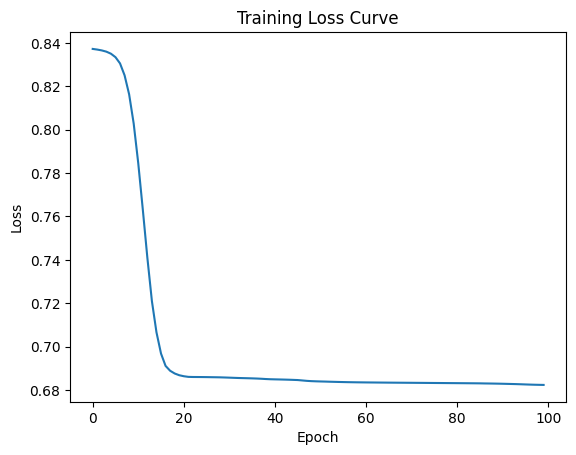

In [ ]:
# Initialize 'model2'
model2 = EdgeDetectionModel2(pretrained=True)

# define the loss function (Binary Cross-Entropy loss)
loss_fn = torch.nn.BCEWithLogitsLoss()

# set epochs
num_epochs = 100  #1000 -> Overfitting to confirm learning

# train model on the first image only
train_model(model2, dataset=dataset2, batch_size=4, loss=loss_fn, epochs=num_epochs)

# SAVING THE MODEL AFTER TRAINING
torch.save(model2.state_dict(), save_path + '/model2.pth')

Load here if needed

In [ ]:
# LOADING
model2 = EdgeDetectionModel2(pretrained=False)
model2.load_state_dict(torch.load(save_path + '/model2.pth'))

<ipython-input-18-73f91a03d99f>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load(save_path + '/model2.pth'))


<All keys matched successfully>

Run inference on the trained model for sanity check:
- process output for vizualization
- plot original image, ground truth, and model prediction

Original image
Tensor Shape: torch.Size([1, 3, 256, 256])
Mean: 0.38130679726600647
Std: 0.23816221952438354
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Ground truth
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.23280619084835052
Std: 0.3140875995159149
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------
Model prediction
Tensor Shape: torch.Size([1, 1, 256, 256])
Mean: 0.10671290010213852
Std: 0.29345178604125977
Min: 0.0
Max: 1.0
---------------------------------------------------------------------------


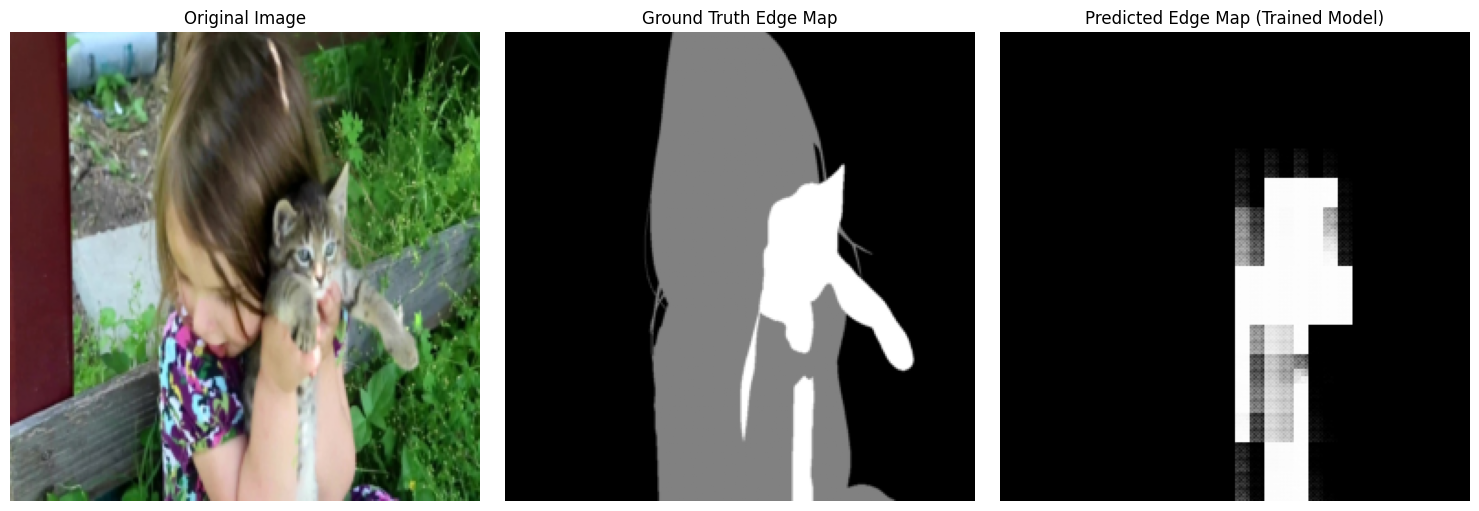

In [ ]:
model2.eval()  # Set model to evaluation mode

original_image, ground_truth = list(dataloader2)[0] # Get a single frame

print("Original image")
tensor_describe(original_image)
print("Ground truth")
tensor_describe(ground_truth)

with torch.no_grad():  # No need to compute gradients during inference
    model_prediction = model2(original_image)  # Get prediction
print("Model prediction")
tensor_describe(normalize_min_max(model_prediction))


# Create a figure with 3 subplots
side_comparison(original_image[0], ground_truth[0].unsqueeze(0), normalize_min_max(model_prediction[0]).unsqueeze(0))

**Observation:** the model has learned (somewhat). We can proceed further and overfit on a video.

## Overfit on a video


The newly chosen video is: bear
Epoch 1/5, Loss: 0.8366
Epoch 2/5, Loss: 0.6789
Epoch 3/5, Loss: 0.6785
Epoch 4/5, Loss: 0.6777
Epoch 5/5, Loss: 0.6773


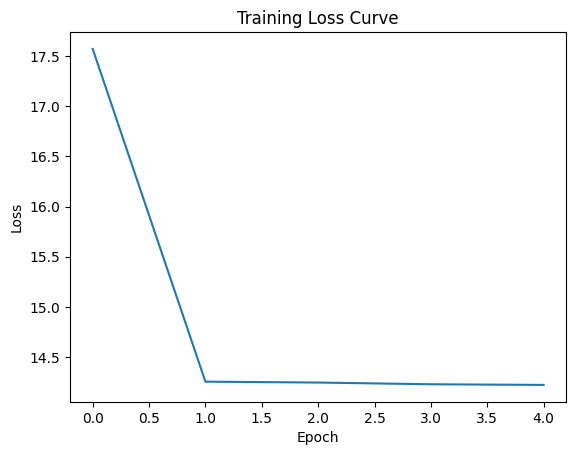

In [ ]:
# Define new video and new paths
video_name3, video_path3, annotation_path3 = pick_video(name="bear")

# reinitialize model
# use the 'EdgeDetectionModel2' architecture from Task 2 with pretrained weights
model3 = EdgeDetectionModel2()
dataset3 = DAVISDataset(image_dir = video_path3, mask_dir = annotation_path3, transform = resize_normalize)
num_epochs = 5
batch_size = 4
loss_fn = torch.nn.BCEWithLogitsLoss()

train_model(model3, dataset=dataset3, batch_size=batch_size, loss=loss_fn, epochs=num_epochs)

# SAVING THE MODEL ONCE TRAINED
torch.save(model3.state_dict(), save_path + '/model3.pth')

Test: run inference on a validation image

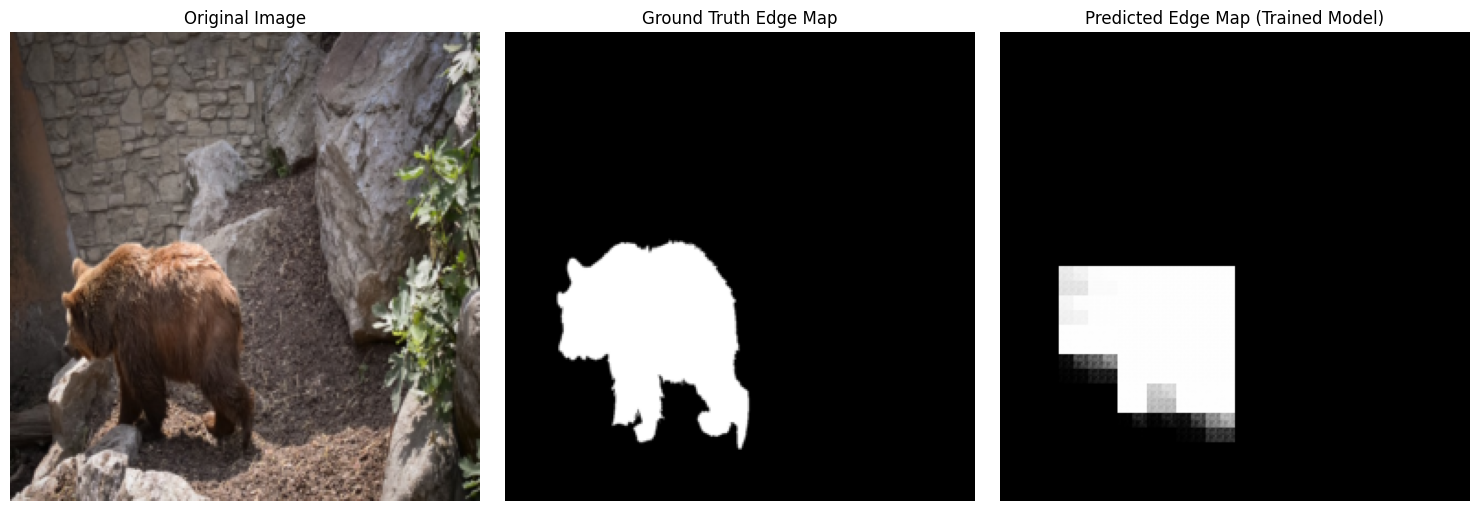

In [ ]:
model3 = EdgeDetectionModel2()
model3.load_state_dict(torch.load(save_path + '/model3.pth'))
model3.eval();

with torch.no_grad():
    # random integer between min and max arg
    N = random.randint(0, len(dataset3)-1)
    test_image, test_mask = dataset3[N]  # Pick a random test frame
    test_image = test_image.unsqueeze(0)  # Add batch dimension
    pred_mask = model3(test_image)  # Predict edge mask


# Plot results
side_comparison(test_image[0], test_mask.unsqueeze(0), normalize_min_max(pred_mask[0]).unsqueeze(0))

## Result of overfitting

Let us try an inference on a different video and visualize it.


We first re-run training on model 3 to ensure overfitting.

Epoch 1/6, Loss: 0.6770
Epoch 2/6, Loss: 0.6770
Epoch 3/6, Loss: 0.6769
Epoch 4/6, Loss: 0.6769
Epoch 5/6, Loss: 0.6769
Epoch 6/6, Loss: 0.6769


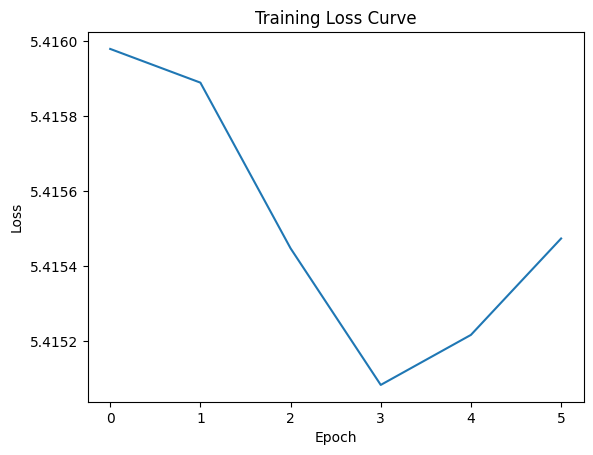


 Achieved re-training over 6


In [ ]:
## RE-RUN THE CELL TO CREATE MORE OVERFIT
# We first re-load our model
model3 = EdgeDetectionModel2()
model3.load_state_dict(torch.load(save_path + '/model3.pth'))

# We set new hyperparameters, but keep the same loss function
epochs=5
lr=0.00001
batch_size=11
epochs =6

# retrain the loaded model to ensure overfit
train_model(model3, dataset=dataset3, batch_size=batch_size, loss=loss_fn, epochs=epochs, lr=lr)
print(f"\n Achieved re-training over {epochs} epochs")

# save
torch.save(model3.state_dict(), save_path + '/model3.pth')

Observations:
- the learning curve has started to stabilize
- progress has become noisy.

This indicates overfit.

The newly chosen video is: bear


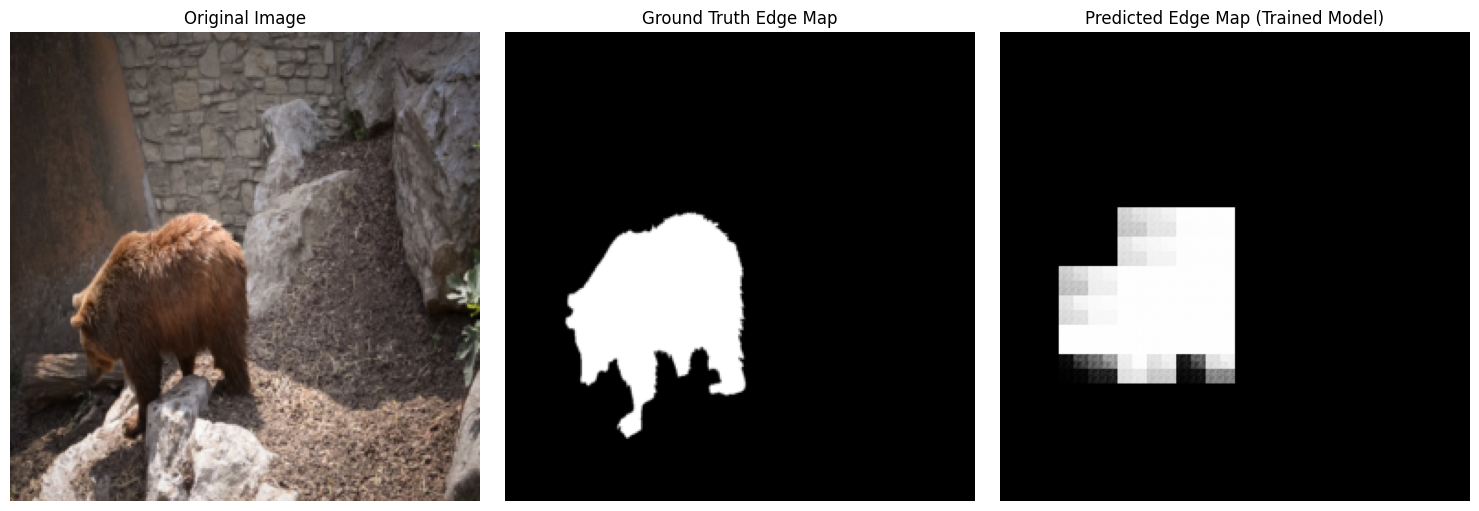

In [ ]:
# we pick a new video
video_name3_test, video_path3_test, annotation_path3_test = pick_video(name="bear")
dataset3_test = DAVISDataset(image_dir = video_path3_test, mask_dir = annotation_path3_test, transform = resize_normalize)

# plot a single frame
model3.eval();
with torch.no_grad():
    # random integer between min and max arg
    N = random.randint(0, len(dataset3_test)-1)
    test_image, test_mask = dataset3_test[N]  # Pick a random test frame
    test_image = test_image.unsqueeze(0)  # Add batch dimension
    pred_mask = model3(test_image)  # Predict edge mask

    side_comparison(test_image[0], test_mask.unsqueeze(0), normalize_min_max(pred_mask[0]).unsqueeze(0))